In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time

from qiskit import BasicAer, Aer
from qiskit.aqua.algorithms import AmplitudeEstimation
from qiskit.aqua.components.uncertainty_models import LogNormalDistribution
from qiskit.aqua.components.uncertainty_problems import UnivariateProblem
from qiskit.aqua.components.uncertainty_problems import UnivariatePiecewiseLinearObjective as PwlObjective

# Load distribution

Map a distribution to quantum states, so a random number $x$ from the distribution can be represented as a quantum state. By using $n$ qubits, we discretize the distribution to $2^n$ grid points. The unitary operator implements the following:
$$
\mathcal{R}  |0\rangle_n
=
|\psi\rangle_n
\displaystyle\sum_{j=0}^{2^n-1}
\sqrt{p_j}
|j\rangle_n
$$
with probability $p_j$ of measuring the state $|j\rangle_n$. The state label goes from $0$ to $2^n-1$, totally $2^n$ choices of random number $x$. The procedure indicates that we truncate distribution to $[S_{T,\text{min}}, S_{T,\text{max}}]$.

### Why do we need to do this?

The price of path-independent canilla options depend only on the distribution of the underlying asset price $S_T$ at the option maturity $T$ and the payoff function $f(S_T)$ of the option.

### Distribution: log-normal (Black-Scholes-Merton model)

The BSM model assumes that the underlying stock prices at maturity $T$ follow a log-normal distribution with constant volatility. The probability density function is
$$
P(S_T)
=
\dfrac{1}{S_T \sigma \sqrt{2\pi T}}
\exp
\left[
-
\dfrac{(\ln S_T - \mu)^2}{2\sigma^2 T}
\right],
$$
where $\sigma$ is the volatility of the asset and $\mu = (r-0.5\sigma^2)T + \ln S_0$ with the risk-free market rate (annual interest rate) $r$ as well as  $S_0$, the initial assets's spot price.

## Set the basic parameters

In [2]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0 # initial spot price
vol = 0.4 # volatility of 40%
r = 0.05 # annual interest rate of 4%
T = 40 / 365 # 40 days to maturity

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low  = np.maximum(0, mean - 3*stddev)
high = mean + 3*stddev

# print the parameters
print('number of loaded qubits:', num_uncertainty_qubits)
print()
print('initial spot price:   \t%.4f' % S)
print('volatility:           \t%.4f' % vol)
print('annual interest rate :\t%.4f' % r)
print('maturty (of one year):\t%.4f' % T)

number of loaded qubits: 3

initial spot price:   	2.0000
volatility:           	0.4000
annual interest rate :	0.0500
maturty (of one year):	0.1096


## Contruct the circuit for the distribution: Encode the distribution to quantum state

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/matplotlib/mathtext.py:2525: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


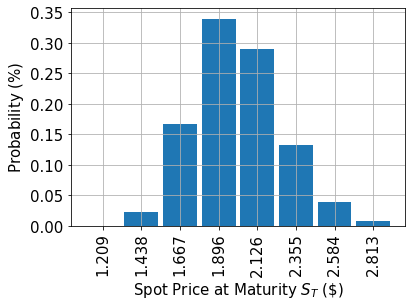

In [3]:
# construct circuit factory for uncertainty model
uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma, low=low, high=high)

# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.show()

# Payoff function

Here the profolio option is chosen to be long-butterfly spread, where the payoff function can be described as
$$
f(S_T)
=
\begin{cases}
  S_T - K_1, &K_1 \leq S_T < K_2 \\
  2K_2 - K_1 - S_T, &K_2 \leq S_T < K_3\\
  0, &\text{otherwise}
\end{cases},
$$
with the price of underlying $S_T$ and strike prices $K_1$, $K_2$. The trader gets profit if the stock price on the expiration date is near the middle exercise price, that is, buying when $S_T \geq K_1$ and $S_T \leq K_2$. 

The implementaiton of the option is then simple to be realized: flip the ancilla qubit from $|0\rangle$ to $|1\rangle$ if profit, do nothing (left the qubit $|0\rangle$ as initially) whenever loss. Hence an unitary operator $\mathcal{A}$ allows:
$$
|0\rangle
\xrightarrow[]{\mathcal{A}}
\begin{cases}
|1\rangle, &\text{if } S_T \geq K_1, S_T \leq K_2 \\
|0\rangle, &\text{otherwise}
\end{cases}
$$

In [4]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price_1 = 1.438
strike_price_2 = 1.896
strike_price_3 = 2*strike_price_2 - strike_price_1

# set the approximation scaling for the payoff function
c_approx = 0.25 # the smaller, the better

# setup piecewise linear objective fcuntion
breakpoints = [uncertainty_model.low, strike_price_1, strike_price_2, strike_price_3]
slopes = [0, 1, -1, 0]
offsets = [0, 0, strike_price_2 - strike_price_1, 0]
f_min = 0
f_max = strike_price_2 - strike_price_1
butterfly_objective = PwlObjective(
    uncertainty_model.num_target_qubits, 
    uncertainty_model.low, 
    uncertainty_model.high,
    breakpoints,
    slopes,
    offsets,
    f_min,
    f_max,
    c_approx
)

# construct circuit factory for payoff function
butterfly = UnivariateProblem(
    uncertainty_model,
    butterfly_objective
)
# print parameters
print('K_1:\t%.4f'% strike_price_1)
print('K_2:\t%.4f'% strike_price_2)
print('K_3:\t%.4f'% strike_price_3)
print()
print('scaling parameter:\t%.4f' % c_approx)

K_1:	1.4380
K_2:	1.8960
K_3:	2.3540

scaling parameter:	0.2500


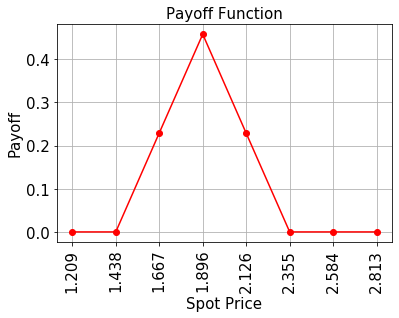

In [5]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
def payoff(x):
    if x <= strike_price_1:
        return 0
    elif x < strike_price_2:
        return x - strike_price_1
    elif x < strike_price_3:
        return 2*strike_price_2 - strike_price_1 - x
    else:
        return 0
y = [payoff(x_) for x_ in x]
plt.plot(x, y, 'ro-')
plt.grid()
plt.title('Payoff Function', size=15)
plt.xlabel('Spot Price', size=15)
plt.ylabel('Payoff', size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

# Exact expected payoff

In [6]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainty_model.probabilities, y)
print('exact expected value:\t%.4f' % exact_value)

exact expected value:	0.2598


# Expected payoff using AE

Amplitude estimation can efficiently (comparing to Monte Carlo method) estimate $a$ in
$$
\mathcal{A}
|0\rangle_{n+1}
=
\sqrt{(1-a)}
|\psi_0\rangle_n |0\rangle
+
\sqrt{a}
|\psi_1\rangle_n |1\rangle,
$$
which is absolutely the combination of the above: loading distribution & payoff option. The first $n$ qubits store the information of the underlying asset price, while the rest of the qubits encode the strike prices.

Enter your subclass object representing the problem unitary.
1. `buterfly` for butterfly spreads
2. `iron_condor` for condor spread

The user can also choose different backend (simulator) to evaluate the expectation value in the `if` statement. We provide two options:
1. `qasm_simulator` that can tune the number of shots
2. `statevector_simulator`

To compare estimated values with different number of qubits for AE, we use a `for` loop with $m \in [m_1, m_2]$ where $m_1$ is the minimal and $m_2$ is the maximal of qubit number $m$. Each step in `for` is determined by $\mathrm{d} m$.

The red dashed line indicates the exact value. For the result of quantum algorithm, the middle value of the highest histogram is the outcome.

Exact value:    	0.2598



/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

Backend: statevector_simulator


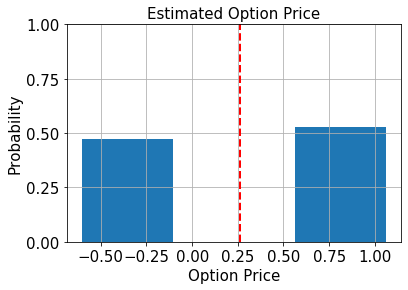

Number of qubits for AE: 1
Estimated value:	0.8121
Probability:    	0.5257
Computational time: 1.4707598686218262 (seconds)



/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/Users/ycldingo/anaconda3/envs/IBMQ/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in 

Backend: statevector_simulator


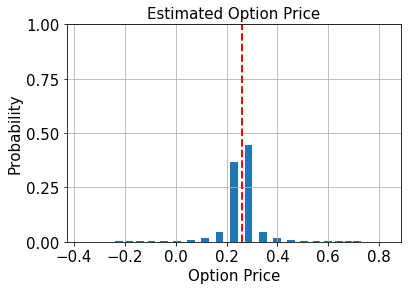

Number of qubits for AE: 6
Estimated value:	0.2862
Probability:    	0.4459
Computational time: 79.48428416252136 (seconds)


In [7]:
# set number of evaluation qubits (=log(samples))
m1 = 1
m2 = 10
dm = 5

# print exact value
print('Exact value:    \t%.4f' % exact_value)

# set backend & run AE
QASM = False 
for m in range(m1, m2, dm):
    # construct amplitude estimation 
    ae = AmplitudeEstimation(m, butterfly) 
    print()
    if QASM:
        shot = 100
        start_time = time.time()
        result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=shot) # QASM
        end_time = time.time()
        print('Number off shots:', shot)
        print('Backend: qasm_simulator')
    else:
        start_time = time.time()
        result = ae.run(quantum_instance=Aer.get_backend('statevector_simulator')) # statevector
        end_time = time.time()
        print('Backend: statevector_simulator')
    cost_time = end_time - start_time
    # plot estimated values for option price (after re-scaling and reversing the c_approx-transformation)
    plt.bar(result['mapped_values'], result['probabilities'], width=1/len(result['probabilities']))
    plt.plot([exact_value, exact_value], [0,1], 'r--', linewidth=2)
    plt.xticks(size=15)
    plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
    plt.title('Estimated Option Price', size=15)
    plt.ylabel('Probability', size=15)
    plt.xlabel('Option Price', size=15)
    plt.ylim((0,1))
    plt.grid()
    plt.show()

    # print information and results
    print('Number of qubits for AE:', m)
    print('Estimated value:\t%.4f' % result['estimation'])
    print('Probability:    \t%.4f' % result['max_probability'])
    print('Computational time: %s (seconds)' % cost_time)



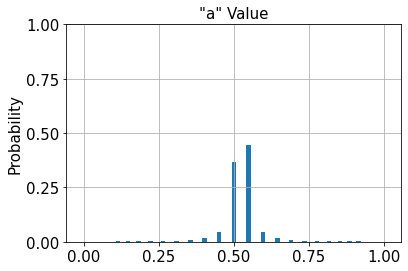

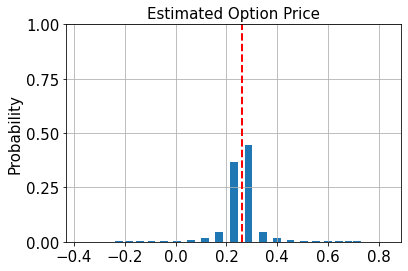

In [8]:
# plot estimated values for "a"
plt.bar(result['values'], result['probabilities'], width=0.5/len(result['probabilities']))
plt.xticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('"a" Value', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

# plot estimated values for option price (after re-scaling and reversing the c_approx-transformation)
plt.bar(result['mapped_values'], result['probabilities'], width=1/len(result['probabilities']))
plt.plot([exact_value, exact_value], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Option Price', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()